In [94]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [95]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import re
import time

window_path = "chromedriver.exe"
source_url = "https://map.kakao.com/"
driver = webdriver.Chrome(window_path)
driver.get(source_url)
searchbox = driver.find_element(By.XPATH, "//input[@id='search.keyword.query']")
searchbox.send_keys("파스타")

searchbutton = driver.find_element(By.XPATH,"//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)
time.sleep(2)
html = driver.page_source

soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저 종료
driver.close()

https://place.map.kakao.com/1319682854
https://place.map.kakao.com/17481755
https://place.map.kakao.com/998258856
https://place.map.kakao.com/15221590
https://place.map.kakao.com/1827047488
https://place.map.kakao.com/27416484
https://place.map.kakao.com/948805101
https://place.map.kakao.com/1737039720
https://place.map.kakao.com/1248010478
https://place.map.kakao.com/923574416
https://place.map.kakao.com/940280185
https://place.map.kakao.com/2035194147
https://place.map.kakao.com/1044921132
https://place.map.kakao.com/2006364085
https://place.map.kakao.com/1760221745


In [148]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

excutable_path = "chromedriver.exe"

driver = webdriver.Chrome(executable_path=excutable_path) 
for page_url in page_urls:
    
    # 상세보기 페이지에 접속
    driver.get(page_url)
    time.sleep(2)
    
    # 첫 페이지 리뷰 크롤링
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"cont_evaluation"})
    
    # 별점
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    # 리뷰
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 리뷰 크롤링
    for button_num in range(5, 10):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행 X
        try:
            another_reviews = driver.find_element(By.XPATH, "//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰 크롤링
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"cont_evaluation"})

            # 별점
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            # 리뷰
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [149]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 2 else 0)
print(df.shape)
df.head()

(15, 3)


,score,review,y
0,4,하이볼 맛없었음…,1
1,4,진짜 말이필요없어요 직접 가보시면 알아요 진짜 최고입니다!,1
2,2,"상하이 해산물 오일파스타.. 매운 오일 파스타를 기대했는데, 볶음짬뽕 맛이었어요 ㅠ...",0
3,4,음식 친절 분위기 모든게 완벽합니다,1
4,3,주차자리 전화로 여쭤보고 3분내로 간다고까지 전화했는데 자리없다고 30분걸릴 것 같...,1


In [150]:
df.to_csv("review_data.csv", index=False)

In [151]:
df = pd.read_csv("review_data.csv")

In [152]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [153]:
# 함수를 적용하여 리뷰에서 한글만 추출
df = pd.read_csv("review_data.csv")
df = df.dropna()
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
0,4,1,하이볼 맛없었음
1,4,1,진짜 말이필요없어요 직접 가보시면 알아요 진짜 최고입니다
2,2,0,상하이 해산물 오일파스타 매운 오일 파스타를 기대했는데 볶음짬뽕 맛이었어요 ㅠㅠ ...
3,4,1,음식 친절 분위기 모든게 완벽합니다
4,3,1,주차자리 전화로 여쭤보고 분내로 간다고까지 전화했는데 자리없다고 분걸릴 것 같다고 ...


In [154]:
from konlpy.tag import Okt

# konlpy라이브러리로 텍스트 데이터에서 형태소 추출
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작 테스트
result = get_pos(df['ko_text'].values[0])
print(result)

['하이/Noun', '볼/Noun', '맛없었음/Adjective']


In [155]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [156]:
X.shape

(13, 169)

In [157]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'하이/Noun': 161, '볼/Noun': 86, '맛없었음/Adjective': 64, '진짜/Noun': 147, '말/Noun': 62, '이/Josa': 127, '필..


In [158]:
print(df['ko_text'].values[0])
print(X[0])

하이볼 맛없었음
  (0, 161)	1
  (0, 86)	1
  (0, 64)	1


In [159]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [160]:
print(X.shape)
print(X[0])

(13, 169)
  (0, 161)	0.5773502691896258
  (0, 86)	0.5773502691896258
  (0, 64)	0.5773502691896258


In [161]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(9, 169)
(4, 169)


In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 1.00
Precision : 1.000
Recall : 1.000
F1 : 1.000


In [168]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[4]]


AUC : 1.000


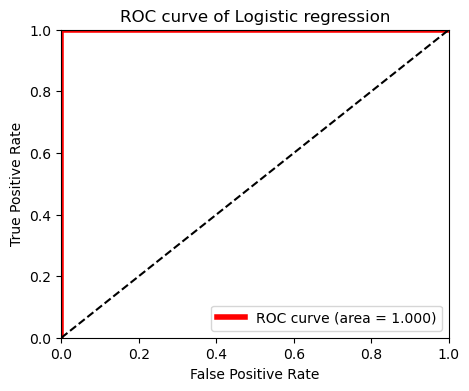

In [135]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")